# Data exploration

This short notebook aims at presenting different aspects of a dataset.
This serves as a data exploration for the input of a Graph Neural Solver. See https://github.com/bdonon/GraphNeuralSolver for more informations.

This notebook should be in a data folder. To ensure that the dataset is valid, I recommend to first run the python script test.py to perform a series of sanity checks on the data.

Now let's investigate this dataset!

In [1]:
import os
import tqdm
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

The dataset is split into 3 parts : train, val and test sets. Instead of taking a look at the whole dataset, we will focus solely on one of these three subparts. You can select the mode you want to look at.

In [2]:
# Define mode of interest (can be 'train', 'val' or 'test')
mode = 'val'

In [3]:
# Import data
A = np.load('A_'+mode+'.npy')
B = np.load('B_'+mode+'.npy')
X = np.load('X_'+mode+'.npy')
coord = np.load('coord_'+mode+'.npy')

## Data description

Our Graph Neural Solver approach aims at providing a framework for solving linear and non-linear systems of equations that share a certain structure. Basically, we are interested in hypergraphs $G=(A,B)$ that define a graphical structure. Let $n$ be the amount of nodes in the hypergraph. Each edge in $A$ is defined by a $d_{in,A}$-dimensional vector.

\begin{align}
    A \in ( \mathbb{R}^{d_{in,A}} )^{n^2}
\end{align}

Each node is defined by a $d_{in,B}$-dimensional vector.

\begin{align}
    B \in ( \mathbb{R}^{d_{in,B}} )^{n^1}
\end{align}

For all $i, j \in [1, \dots, n]$, $[A]_{ij} \in \mathbb{R}^{d_{in,A}}$ and $[B]_{i} \in \mathbb{R}^{d_{in,B}}$

In addition to this hypergraph, a problem is also defined by two force templates: $(\overline{F}, \mathring{F})$ that respectively decribe an interaction force between direct neighbors of the graph, and a counteraction force for each node. Ideally, we would like to find a function $f^* : (A,B) \mapsto X^*$ with $X^*$ defined by the following system:

\begin{align}
    \forall i \in [1,\dots,n], \mathring{F}([X]_i, [B]_i) + \sum_{j\in \mathcal{N}_i} \overline{F}([X]_i, [X]_j, [A]_{ij}) = 0
\end{align}

where $\mathcal{N}_i$ is the set of neighbors of node $i$ as defined in $A$.

For any function $f : (A,B) \mapsto X$ we define the residual $\text{res}(f;A,B)$:

\begin{align}
    \forall i \in [1,\dots,n], [\text{res}(f;A,B)]_i = \mathring{F}([f(A,B)]_i, [B]_i) + \sum_{j\in \mathcal{N}_i} \overline{F}([f(A,B)]_i, [f(A,B)]_j, [A]_{ij})
\end{align}

Current methods try to solve this system without any (or too much) assumptions about the distributions of tensors $A$ and $B$. However, in many cases, we know that our data $A$ and $B$ lies in a quite small part of their respective spaces, and we want to exploit it by making use of tools from the statistical learning theory. Let's say that we know that our data is sampled from a space with a certain measure : $(\mathcal{G}, d\mu)$. The basic idea of the Graph Neural Solver approach is to search in a space of parametric functions (parameterized by $\theta$) $(f_{\theta} | \theta \in \Theta)$ and to try to minimize the following objective:

\begin{align}
    Loss = \int_{G=(A,B) \in \mathcal{G}} \Vert res(f_{\theta};A,B) \Vert d\mu(G)
\end{align}

For more informations about the approach, feel free to check my blog : bdonon.github.io

### Tensor A

Our dataset contains a batch of tensors A. These tensors are presented in a sparse way. Below is shown a sample of a few lines. The first column corresponds to the origin of each line, the second to the extremity, and the other lines to each of the coefficients in $A_{ij}$. Having the first two columns represent the indices of origin and extremity adds cause the tensor A's last dimension to be equal to $d_{in,A}+2$.


In [4]:
index = 0
print('In this dataset, we have d_in_A = {}'.format(np.shape(A)[-1]-2))
print('Here is a sample of a few lines:')
print(A[index, :5])

In this dataset, we have d_in_A = 1
Here is a sample of a few lines:
[[ 4.          1.         -1.01473105]
 [ 4.          2.         -0.17968258]
 [ 4.          3.         -0.60314157]
 [ 4.          5.         -0.43942404]
 [ 4.          7.         -0.80511212]]


### Tensor B

Tensors B are represented in a much more conventional way. 

In [5]:
index = 0
print('In this dataset, we have d_in_B = {}'.format(np.shape(B)[-1]))
print('Here is a sample of a few nodes:')
print(B[index, :5])

In this dataset, we have d_in_B = 3
Here is a sample of a few nodes:
[[ 0.00000000e+00  1.00000000e+00  4.99505836e+01]
 [ 0.00000000e+00  1.00000000e+00  5.06964847e+01]
 [ 0.00000000e+00  1.00000000e+00  5.08047843e+01]
 [ 0.00000000e+00  1.00000000e+00  5.14554774e+01]
 [-9.82281533e-03  0.00000000e+00  0.00000000e+00]]


### Tensor X

Tensors X correspond to a solution to the system of equations that is given by a more "traditional" approach. Although it is not used during the training of a model, it is still useful to have it for visualization and debug purposes. Their dimension is $d_{out}$, and we have $X \in \left( \mathbb{R}^{d_{out}} \right)^{n^1}$.

In [6]:
index = 0
print('In this dataset, we have d_out = {}'.format(np.shape(X)[-1]))
print('Here is a sample of a few nodes:')
print(X[index, :5])

In this dataset, we have d_out = 1
Here is a sample of a few nodes:
[[49.95058362]
 [50.69648475]
 [50.80478432]
 [51.45547744]
 [51.92625229]]


### .tfrecords files

Tensors $A$, $B$ and $X$ are all in two formats : .npy (easily readable with numpy), and .tfrecords (better for the training using tensorflow). They should be exactly the same (although their may be some very slight discrepency).

### Coordinates

All samples also have some 2D coordinates, for visualization purposes. The model does not use them.

In [7]:
index = 0
print('Here is a sample of a few nodes:')
print(coord[index, :5])

Here is a sample of a few nodes:
[[1.02179572 1.27101774]
 [1.05066837 1.26269183]
 [1.02912309 1.29092742]
 [1.07954102 1.25436593]
 [1.07104931 1.27914367]]


### problem.py

This file is extremely important : it defines both the dimensions of the problem ($d_{in,A}$, $d_{in,B}$, $d_{out}$ and $d_{F}$) as well as the basic templates for the forces $\mathring{F}$ and $\overline{F}$. Take a look at the code it contains to better familiarize yourself with it.

### test.py

This piece of code checks a series of properties that a proper dataset should respect:

    1) All required files are present;
    2) All files of the same mode (train, val or test) have the same amount of sample;
    3) All tensors are rank 3;
    4) Dimensions specified in problem.py are consistent with the actual data;
    5) All files of the same mode have the same amount of nodes;
    6) .npy and .tfrecords files are identical to a certain precision level;
    7) Make sure that the provided expressions for forces are compliant with the provided dimensions;
    8) Make sure that X is a good approximation of the solution.

# Plots!

Now that all the required files have been described, let's plot our data to better understand it!

## Graph Structures



There is just a bit of preprocessing to perform before being able to plot things. Since our input data can be of various sizes, we have chosen to pad smaller graph with dummy nodes so that all graphs in our dataset have the same amount of nodes. So we want to get rid of these dummy nodes before plotting anything.

Here are 4 samples from our chosen dataset:


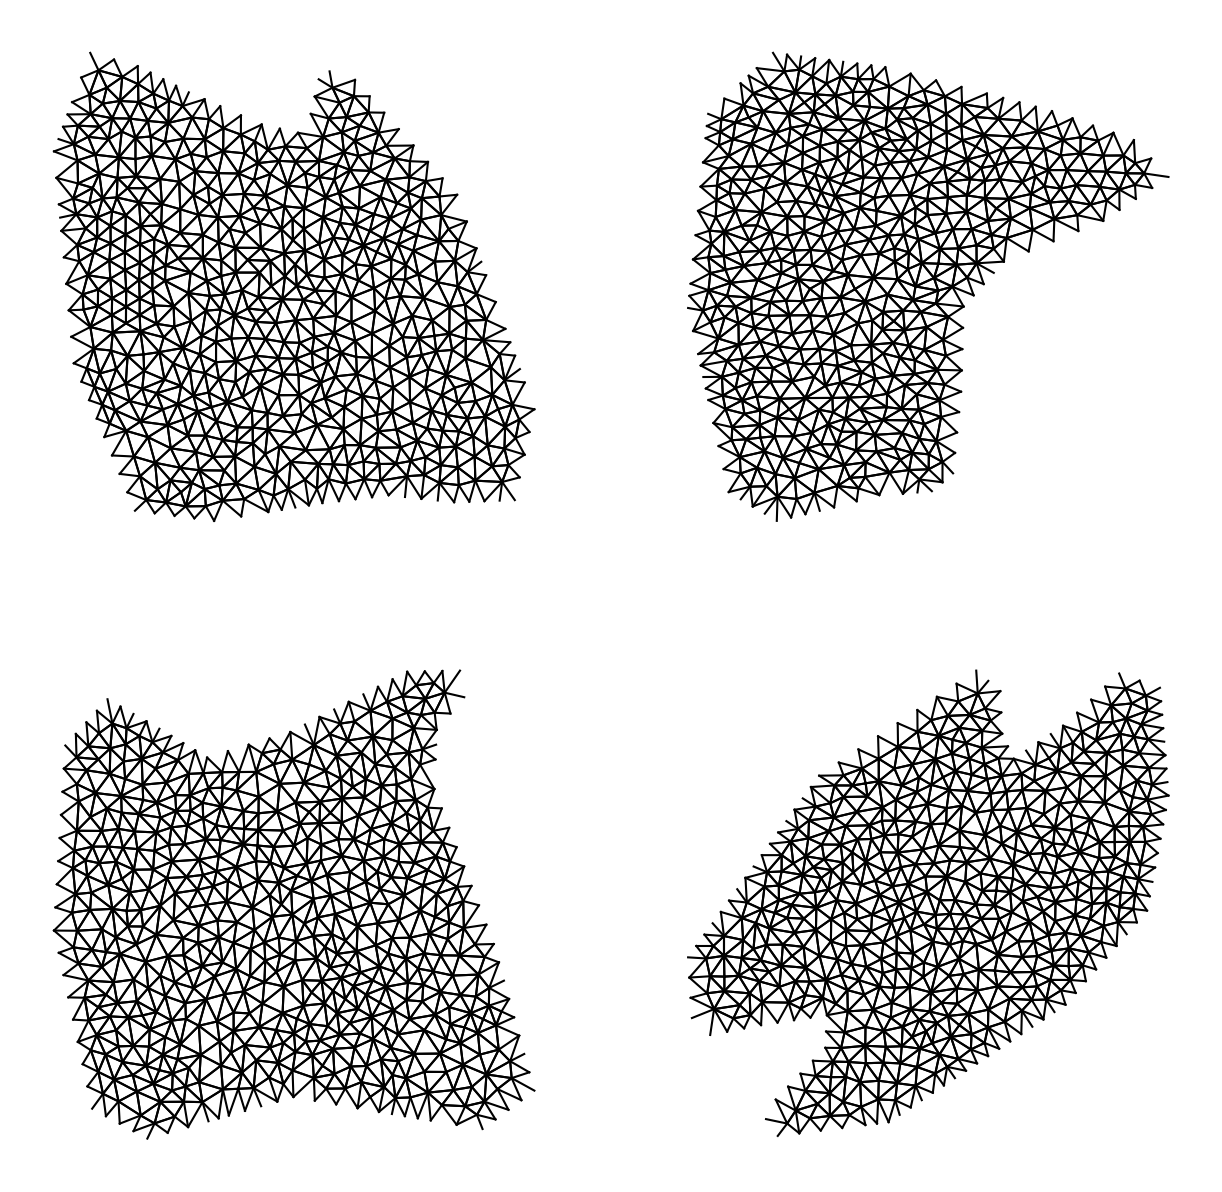

In [30]:
print("Here are 4 samples from our chosen dataset:")

# Plot 4 samples for each dataset

# Sample 4 samples
n_samples = np.shape(A)[0]
indices = np.random.randint(0, n_samples, 4)


plt.figure(figsize=[5,5], dpi=300)
for i in range(4):
    
    # Get sampled index
    index = indices[i]
    X_gt = X[index, :, 0]

    # Identifying non-dummy nodes
    useful_id = (X_gt!=0.)
    X_gt = X_gt[useful_id]

    # Build mesh
    edges_or = A[index, :, 0].astype(np.int32)
    edges_ex = A[index, :, 1].astype(np.int32)

    coordinates = coord[index, useful_id]
    coordinates_or_x = coordinates[edges_or, 0]
    coordinates_or_y = coordinates[edges_or, 1]
    coordinates_ex_x = coordinates[edges_ex, 0]
    coordinates_ex_y = coordinates[edges_ex, 1]

    coordinates_edge_x = np.c_[coordinates_or_x, coordinates_ex_x]
    coordinates_edge_y = np.c_[coordinates_or_y, coordinates_ex_y]

    plt.subplot(2, 2, i+1)
    plt.plot(coordinates_edge_x.T, coordinates_edge_y.T, 'k', linewidth=0.5)
    plt.axis('off')


plt.show()
    
    

## Distribution of input data values

As seen above, $B$ defines a vector of size $d_{in,B}$ for each node, and $A$ defines a vector of size $d_{in,A}$ for each existing edge. Let's visualize some statistics, for each node and edge and for each components of the corresponding vectors.

Remember that we have d_in_A = 1 and d_in_B = 3


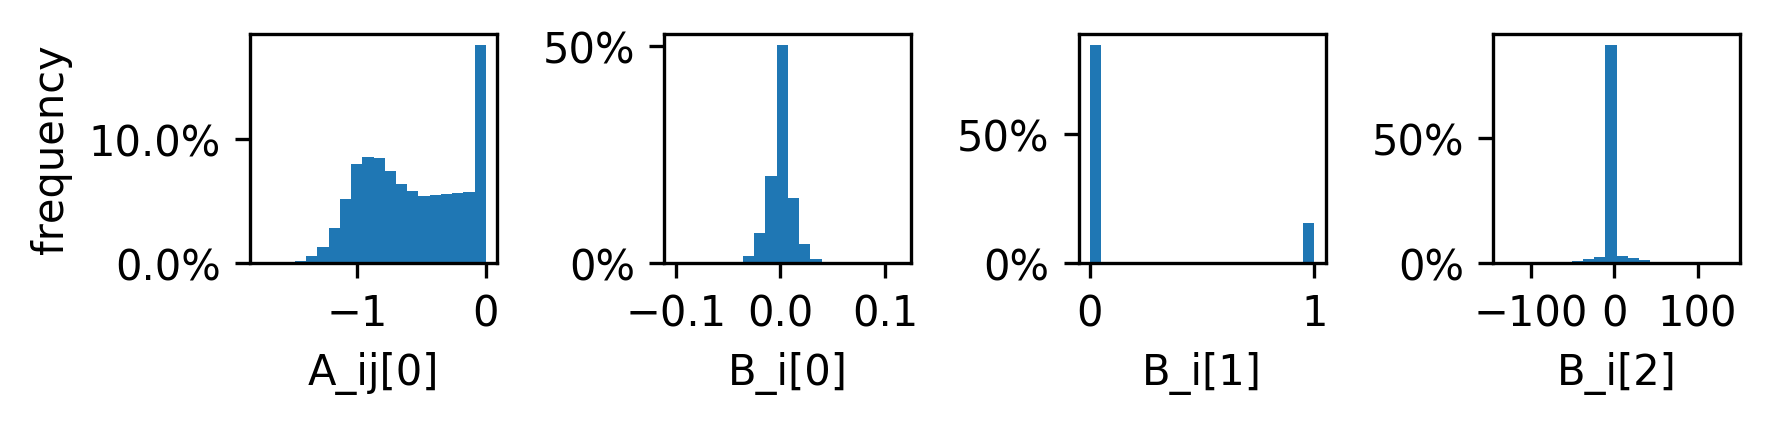

In [29]:
d_in_A = np.shape(A)[-1]-2
d_in_B = np.shape(B)[-1]
print('Remember that we have d_in_A = {} and d_in_B = {}'.format(d_in_A, d_in_B))


plt.figure(figsize=[1.5*(d_in_A+d_in_B),1.5], dpi=300)
for d_A in range(d_in_A):
    A_flat = np.reshape(A[:,:,d_A+2], -1)
    plt.subplot(1, d_in_A+d_in_B, d_A+1)
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    #plt.yscale('log')
    plt.xlabel('A_ij[{}]'.format(d_A))
    if d_A == 0:
        plt.ylabel('frequency')
    plt.hist(A_flat, 
             bins=20,
             weights=np.ones(len(A_flat)) / len(A_flat))

for d_B in range(d_in_B):
    B_flat = np.reshape(B[:,:,d_B], -1)
    plt.subplot(1, d_in_A+d_in_B, d_B+1+d_in_A)
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    #plt.yscale('log')
    plt.xlabel('B_i[{}]'.format(d_B))
    #plt.ylabel('frequency')
    plt.hist(B_flat, 
             bins=20,
             weights=np.ones(len(B_flat)) / len(B_flat))

plt.tight_layout()
plt.show()

## Graph statistics

Let's take a look at quantities from the theory of graph that are of primary importance for our proposed approach: the diameter of each sample, and the degree of each node.

In [10]:
def build_matrix(A_sparse):
    """
    Builds a dense matrix A from its sparse representation
    Input
        - A_sparse : np.float [n_edges, d_in_A+2]
    Output
        - A_dense : np.float [n_nodes, n_nodes, d_in_A]
    """
    
    # Extract values from A_sparse
    or_edges = A_sparse[:,0].astype(np.int32)
    ex_edges = A_sparse[:,1].astype(np.int32)
    val_edges = A_sparse[:,2:]
    
    # Get relevant dimensions
    n_nodes = np.max(A_sparse[:,:2])
    n_nodes = n_nodes.astype(np.int32)+1
    n_edges = np.shape(A_sparse)[0]
    d_in_A = np.shape(A_sparse)[-1]-2
    
    # Fill an empty matrix with the info from A_sparse
    A_dense = np.zeros([n_nodes, n_nodes, d_in_A])
    for i in range(n_edges):
        A_dense[or_edges[i], ex_edges[i]] += val_edges[i]
        
    return A_dense

In [11]:
diameters = []
degrees = []

# This computation can be extremely slow, so modify the following parameter to specify how many sample
# you want to investigate
n_invest = 100

for graph_id in tqdm.tqdm(np.random.randint(0, n_samples, n_invest)):
    
    # Get sample and build dense matrix
    A_sample = A[graph_id]
    A_dense = build_matrix(A_sample)
    
    # Flatten the last dimension:
    A_flat = np.sum(A_dense, axis=2)

    # Build the networkx graph
    G = nx.from_numpy_array(A_flat)
    
    # Get the largest connected component
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
    G0 = G.subgraph(Gcc[0])
    
    # Store diameter
    diameters.append(nx.diameter(G0))
    
    # Store degrees
    
    degrees.extend([d for n, d in G0.degree()])

100%|██████████| 100/100 [10:08<00:00,  6.08s/it]


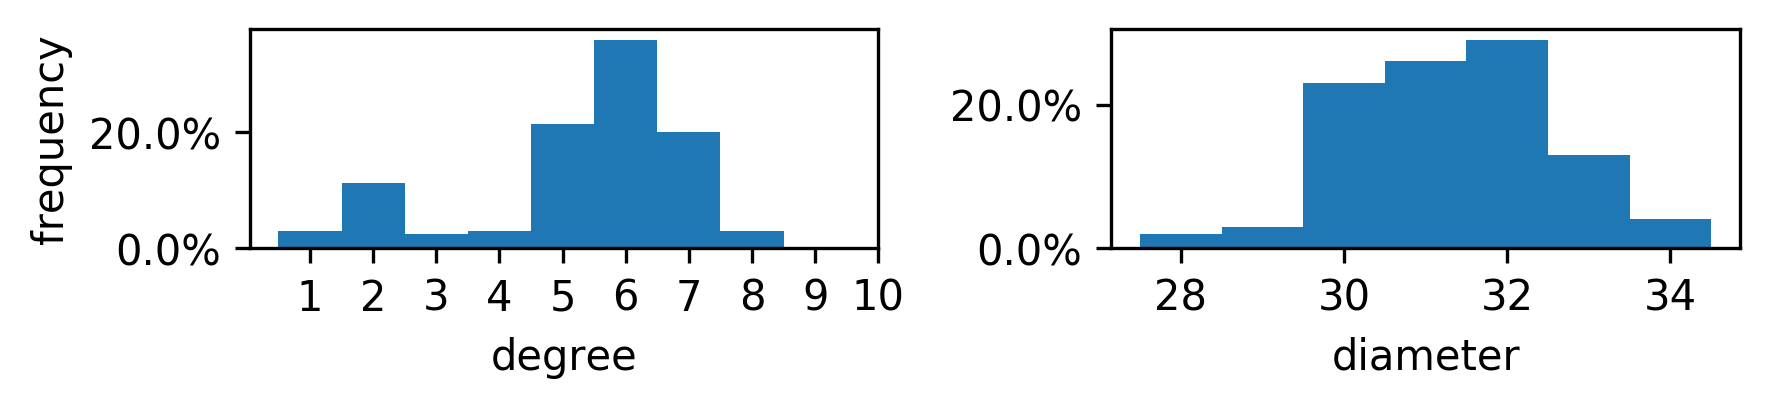

In [33]:
plt.figure(figsize=[6, 1.5], dpi=300)

# Degrees
degrees = np.array(degrees)
bins = np.arange(degrees.min() , degrees.max() + 1.5) - 0.5

plt.subplot(1, 2, 1)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel('degree')
plt.ylabel('frequency')
plt.hist(degrees,
         bins,
         weights=np.ones(len(degrees)) / len(degrees))
plt.xticks(bins + 0.5)

# Diameters
diameters = np.array(diameters)
bins = np.arange(diameters.min(), diameters.max() + 1.5) - 0.5

plt.subplot(1, 2, 2)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel('diameter')
#plt.ylabel('frequency')
plt.hist(diameters,
         bins, 
         weights=np.ones(len(diameters)) / len(diameters))

plt.tight_layout()
plt.show()